In [ ]:
# download testing dataset
!gdown --id 1DFskNCXvHKdHhuaQtCevyoILci-pmNEO

In [34]:
import zipfile
import os

TEST_DATA_DIR = os.path.join('..', 'data', 'test')
# with zipfile.ZipFile('test_set.zip', 'r') as zip_ref:
#     zip_ref.extractall(TEST_DATA_DIR)
TEST_FILENAMES = os.listdir( TEST_DATA_DIR )

# Testing script:

We load the model and the testing dataset. Make predictions and, in the case of labels being present, compute the score.


In [31]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from IPython.display import Image, display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import os

sns.set_style('darkgrid')

BASE_DATA_DIR = os.path.join('..', 'data', 'train')
MODEL_PATH = os.path.join('best_model')
TESTING_SET_FILE = os.path.join('..', 'data', 'testing_set.csv')

# Identify testing data
# TEST_DATA_DIR = os.path.join('..', 'data', 'train')
# TEST_FILENAMES = pd.read_csv( TESTING_SET_FILE )['file'].values

## PARAMS
IMAGE_SIZE = 224

## 01. Model Loading/Definition:

In [32]:
def load_cnn_model(model_path):
    return keras.models.load_model(model_path, custom_objects={'macro_f1': None})

def load_image( image_path, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """ Loads a random image for the patient"""
    img = tf.io.read_file( image_path )
    img = tf.io.decode_image( img, channels=3, expand_animations=False )
    img = tf.image.resize( img, img_size )
    return img

CLASS_NAMES = np.array(['N', 'P', 'T'])
final_model = load_cnn_model(MODEL_PATH)

## 02. Predict images:

Load the testing set and compute the predictions.

In [ ]:
testing_results = []
for image_name in tqdm( TEST_FILENAMES ):
    image_path = os.path.join( TEST_DATA_DIR, image_name )
    
    tensor_image = tf.expand_dims( load_image( image_path ), axis=0)
    model_output = tf.argmax( final_model(tensor_image), axis=1)[0]
    output_label = CLASS_NAMES[model_output]
    testing_results.append( {'file': image_name, 'label': output_label})
    
# store file
testing_results = pd.DataFrame.from_records( testing_results )
testing_results.to_csv('test_results.csv', index=False)
testing_results

Show the distribution of classes. It should be similar to the training distribution.

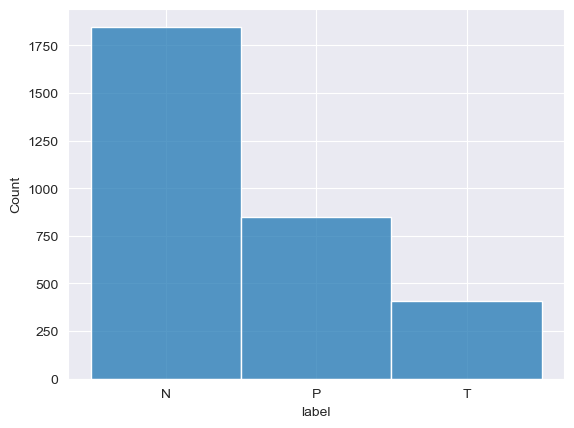

In [21]:
sns.histplot(data=testing_results, x='label')
plt.show()

### 2.1 Check predictions:

In this case we compute the score ( if the input set has labels ).

In [28]:
test_files = os.path.join('..', 'data', 'testing_set.csv')
test_data = pd.read_csv(test_files)

# change name
merged_results = testing_results.merge( test_data, on='file').rename({'label_x': 'prediction', 'label_y': 'label'}, axis=1)
merged_results

,file,prediction,label,patient_id
0,P00002_1.png,N,N,P00002
1,P00003_1.png,N,N,P00003
2,P00004_1.jpeg,N,N,P00004
3,P00006_1.png,N,N,P00006
4,P00006_2.png,N,N,P00006
...,...,...,...,...
3100,P16077_1.png,N,N,P16077
3101,P16082_1.png,N,N,P16082
3102,P16085_1.png,N,N,P16085
3103,P16104_1.png,N,N,P16104


In [29]:
from sklearn.metrics import f1_score

f1_score( merged_results['label'].values, merged_results['prediction'].values, average=None )

array([0.9889992 , 0.99882214, 0.95031847])